In [550]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


In [551]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [552]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Null: non-stationary)
result_adf = adfuller(df['GDP'])
print("ADF p-value:", result_adf[1])

# KPSS Test (Null: stationary)
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df['GDP'], regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.6825705492402232
KPSS p-value: 0.01


/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_17171/3196527536.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['GDP'], regression='c')


In [553]:
# Because GDP is non-stationary, need to difference it
df['GDP_diff'] = df['GDP'].diff().dropna()
fitted_diff = results_high.fittedvalues['GDP_diff']
fitted_level = fitted_diff.cumsum() + df['GDP'].iloc[0]


In [554]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Null: non-stationary)
result_adf = adfuller(df['r'])
print("ADF p-value:", result_adf[1])

# KPSS Test (Null: stationary)
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df['r'], regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.22215361074121293
KPSS p-value: 0.01


/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_17171/1453321110.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['r'], regression='c')


In [555]:
# Because r is non-stationary, need to difference it
df['r_diff'] = df['r'].diff().dropna()

In [556]:
threshold_var = df['Bitcoin'].shift(1) # lagged threshold
theta = threshold_var.median()

regime_low = df[threshold_var <= theta]. dropna()
regime_high = df[threshold_var > theta].dropna()

#Select VAR variables
vars_to_model = ['GDP_diff', 'r_diff']

#Fit VAR on low volatility regime
model_low = VAR(regime_low[vars_to_model])
results_low = model_low.fit(maxlags=1)

# Fit VAR on high-volatility regime
model_high = VAR(regime_high[vars_to_model])
results_high = model_high.fit(maxlags=1)

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [557]:
print ("LOW volatility regime:")
print(results_low.summary())

print("HIGH volatility regime:")
print(results_high.summary())

LOW volatility regime:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 12, Jun, 2025
Time:                     14:02:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.2962
Nobs:                     39.0000    HQIC:                   10.1321
Log likelihood:          -300.462    FPE:                    22945.1
AIC:                      10.0403    Det(Omega_mle):         19784.3
--------------------------------------------------------------------
Results for equation GDP_diff
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             -59.776045       110.183148           -0.543           0.587
L1.GDP_diff        -0.254731         0.138619           -1.838           0.066
L1.r_diff        2248.008808       455.543

/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_17171/753619206.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.Series(forecast_high[:,0], index=pd.date_range(start=df.index[-1], periods=5, freq='M')),


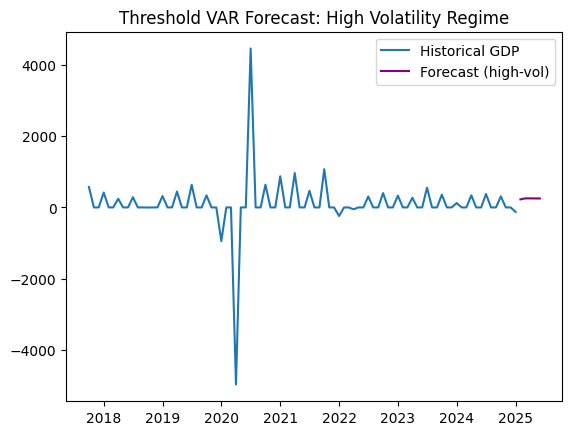

In [558]:
forecast_high = results_high.forecast(y=regime_high[vars_to_model].values[-1:], steps=5)

plt.plot(df['GDP_diff'], label='Historical GDP')
plt.plot(pd.Series(forecast_high[:,0], index=pd.date_range(start=df.index[-1], periods=5, freq='M')),
         label='Forecast (high-vol)', color='purple')
plt.legend()
plt.title("Threshold VAR Forecast: High Volatility Regime")
plt.show()


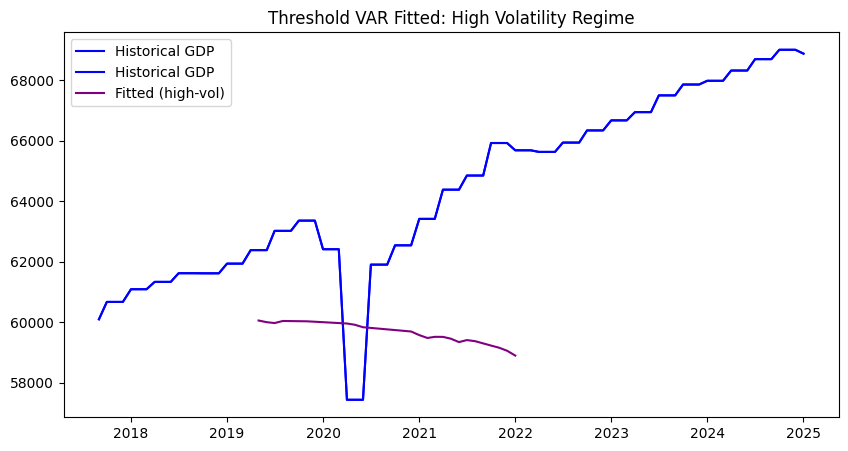

In [559]:
# Historical GDP
plt.figure(figsize=(10, 5))
plt.plot(df['GDP'], label='Historical GDP', color='blue')

# Fitted values from the high-volatility regime
plt.plot(df['GDP'], label='Historical GDP', color='blue')
plt.plot(fitted_level, label='Fitted (high-vol)', color='purple')
plt.title("Threshold VAR Fitted: High Volatility Regime")
plt.legend()
plt.show()



## Training model on 2018-2022 and forecasting 2023-2025 with VAR

In [560]:
# Split the data into training and testing sets
train = df.loc['2017-09':'2022-01']
test = df.loc['2022-02': '2025-1']

In [561]:
from statsmodels.tsa.api import VAR

data = train[['GDP_diff', 'Bitcoin']].dropna()
model = VAR(data)
results = model.fit(maxlags=1)

forecast = results.forecast(y=train[['GDP_diff', 'Bitcoin']].values[-1:], steps=len(test))



/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


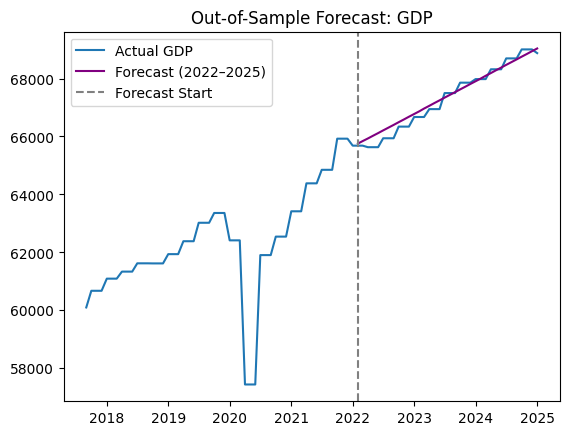

In [562]:
# Extract the GDP forecast (column 0)
forecast_series = pd.Series(forecast[:, 0], index=test.index)

# Starting from the last known actual GDP level
gdp_start = df['GDP'].loc[train.index[-1]]

# Reconstruct GDP forecast from differences
forecast_gdp = forecast_series.cumsum() + gdp_start

# Plot results
import matplotlib.pyplot as plt

plt.plot(df['GDP'], label='Actual GDP')
plt.plot(forecast_gdp, label='Forecast (2022–2025)', color='purple')
plt.axvline(x=pd.to_datetime('2022-02-01'), linestyle='--', color='gray', label='Forecast Start')
plt.title("Out-of-Sample Forecast: GDP")
plt.legend()
plt.show()


In [563]:
# calculate the mean absolute error (MAE) for the forecast
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Error (MAE) of the forecast:", mae)

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Percentage Error (MAPE) of the forecast:", mape)

Mean Absolute Error (MAE) of the forecast: 182.85800837246884
Mean Absolute Percentage Error (MAPE) of the forecast: 0.0027356938046813493


## Testing the same data with TVAR

In [564]:
# defining the threshold
theta = df['Bitcoin'].median()

In [565]:
#split the training data into two regimes
train = df['2017-09':'2022-01'].dropna()
regime_low = train[train['Bitcoin'] <= theta]
regime_high = train[train['Bitcoin'] > theta]

In [566]:
# fit a VAR model to each of the regimes
model_low = VAR(regime_low[['GDP_diff', 'Bitcoin']])
results_low = model_low.fit(maxlags=1)

model_high = VAR(regime_high[['GDP_diff', 'Bitcoin']])
results_high = model_high.fit(maxlags=1)

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [567]:
# forecast loop using regime switching
forecast_steps = len(df['2022-02': '2025-01'])
initial_values = train[['GDP_diff', 'Bitcoin']].values[-1:].copy()

forecast_results = []
current_values = initial_values.copy()

for i in range(forecast_steps):
    vol_index = len(train) + i - 1  # lagged Bitcoin
    btc_vol = df['Bitcoin'].iloc[vol_index]

    # Choose the appropriate model
    model = results_high if btc_vol > theta else results_low

    # Forecast one step
    forecast = model.forecast(current_values, steps=1)
    forecast_results.append(forecast[0])  # flatten the result

    # Update current_values for next step
    current_values = np.vstack([current_values[1:], forecast])

In [568]:
forecast_array = np.array(forecast_results)
forecast_df = pd.DataFrame(forecast_array, columns=['GDP_diff', 'Bitcoin'], index=df['2022-02':'2025-01'].index)

# Reconstruct GDP level
gdp_start = df['GDP'].loc[train.index[-1]]
forecast_gdp = forecast_df['GDP_diff'].cumsum() + gdp_start

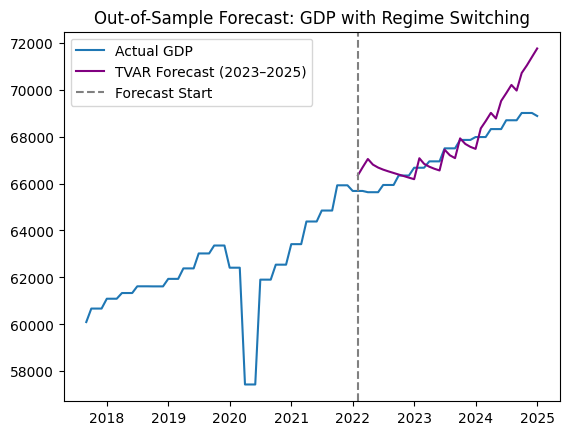

Low Volatility Regime Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 12, Jun, 2025
Time:                     14:02:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.3136
Nobs:                     14.0000    HQIC:                   12.0144
Log likelihood:          -118.008    FPE:                    171649.
AIC:                      12.0397    Det(Omega_mle):         116412.
--------------------------------------------------------------------
Results for equation GDP_diff
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            2186.441053      3221.474751            0.679           0.497
L1.GDP_diff        -0.019109         0.320435           -0.060           0.952
L1.Bitcoin        884.350983      

In [569]:
# plot the forecast 
plt.plot(df['GDP'], label='Actual GDP')
plt.plot(forecast_gdp, label='TVAR Forecast (2023–2025)', color = 'purple')
plt.axvline(x=pd.to_datetime('2022-02-01'), linestyle='--', color='gray', label='Forecast Start')
plt.legend()
plt.title("Out-of-Sample Forecast: GDP with Regime Switching")
plt.show()

# Print the summary of the VAR model results
print("Low Volatility Regime Summary:")
print(results_low.summary())

print("High Volatility Regime Summary:")
print(results_high.summary())
# Print the forecast results
print("Forecast Results:")
print(forecast_df.head())
# Print the fitted values for the high-volatility regime
print("Fitted Values (High Volatility Regime):")
print(fitted_level.head())


In [570]:
# calculate the mean absolute error (MAE) for the forecast
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Error (MAE) of the forecast:", mae)

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Percentage Error (MAPE) of the forecast:", mape)

Mean Absolute Error (MAE) of the forecast: 758.8680687245292
Mean Absolute Percentage Error (MAPE) of the forecast: 0.011206970325288165
